In [ ]:
!pip install opencv_contrib_python==3.4.2.17 --force-reinstall

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow

# Verify OpenCV version
print(cv.__version__)

3.4.2


# Caricamento immagini 

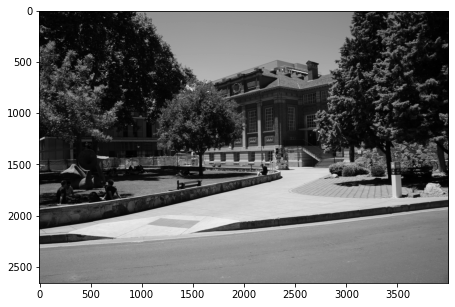

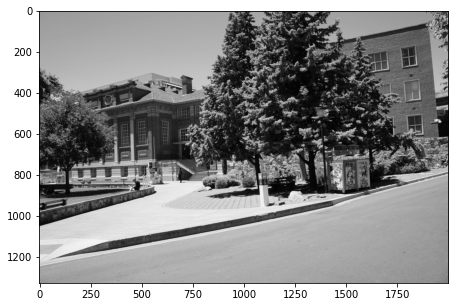

In [11]:
# Image loading
plt.rcParams['figure.figsize'] = [15, 5] # width, height
im1 = cv.imread('images/DSC02930.jpg', 0)
im2 = cv.imread('images/DSC02931.jpg', 0)
plt.imshow(im1, cmap='gray'); plt.show()
plt.imshow(im2, cmap='gray'); plt.show()

# Stitching point delle immagini e matching 

In [12]:
# Keypoints extraction
sift = cv.xfeatures2d.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher(crossCheck=True)
matches = bf.match(features1, features2)

In [13]:
len(kps1)

81981

In [14]:
len(kps2)

18122

# Omografia della trasformazione dal secondo set al primo

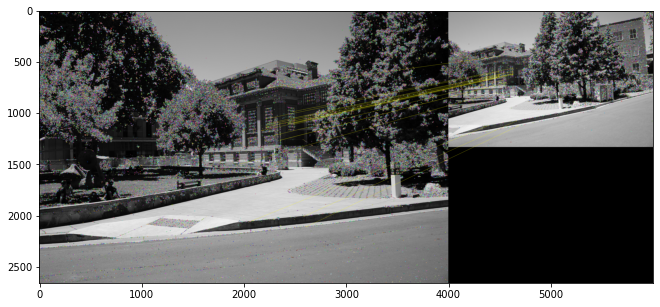

In [15]:
# Visualization of only filtered matches
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(im1, kps1, im2, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

In [64]:
def myHomography(kps1, kps2, matches):
  #takes only best matches
  matches = matches[0:10]
  #findHomography function with the least squares method
  matrix, mask =  cv.findHomography(np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2), np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2), 0,5.0)
  return matrix

In [65]:
H = myHomography(kps1, kps2, matches)

In [66]:
H

array([[ 7.13223528e-01, -1.98401840e-02, -9.46434383e+02],
       [ 7.75258986e-02,  6.37268457e-01, -1.02738130e+02],
       [ 1.16431510e-04, -8.42122750e-06,  1.00000000e+00]])

# Applico l'omografia alla seconda immagine

In [130]:
def warpImages(img1, img2, H):
  #apply transofrmation with homography
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]
  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)
  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
  #calculate dim of the image
  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel())
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel())
  translation_dist = [-x_min,-y_min]
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
  #warpperspective function to apply transformation to img2 with homography
  output_img = cv.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  #concatenate img1 in the result
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
  return output_img

In [131]:
result = warpImages(im2, im1, H)

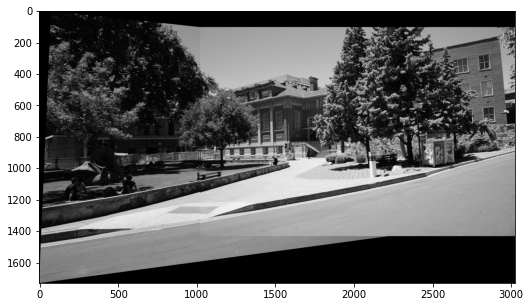

In [132]:
plt.imshow(result, cmap='gray'); plt.show()

# Crop dell'immagine per ritagliare i bordi neri

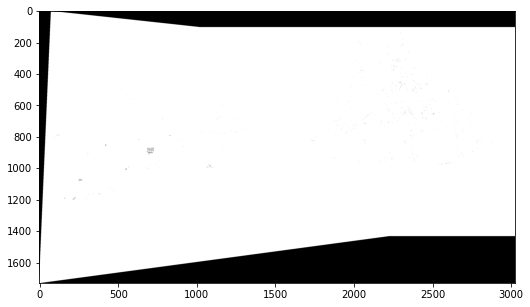

In [189]:
# create a 10 pixel border surrounding the stitched image
stitched = cv.copyMakeBorder(result, 10, 10, 10, 10, cv.BORDER_CONSTANT, (0, 0, 0))
# set all pixels greater than zero to 255 (foreground) while all others remain 0 (background)
thresh = cv.threshold(result, 0, 255, cv.THRESH_BINARY)[1]
plt.imshow(thresh, cmap='gray');

Ho creato una maschera

In [190]:
topleft_corner = []; 
bottomright_corner = []; 
rectangle_heights= []; 
rectangle_areas = [];
#lets start scanning from the left and find the outer two points in each vertical line
for i in range(0,thresh.shape[1]):
    line = thresh[:,i]
    foreground_indecies = np.where(line == 255)
    top_p1 = foreground_indecies[0][0]
    bottom_p1 = foreground_indecies[0][-1]
    line1_length = bottom_p1 - top_p1
    #scan the mask fromt the right side
    for j in range(thresh.shape[1]-1,i+2,-1):
        line2 = thresh[:,j]
        foreground_indecies = np.where(line2 == 255)
        top_p2 = foreground_indecies[0][0]
        bottom_p2 = foreground_indecies[0][-1]
        #find length of right line
        line2_length = bottom_p2 - top_p2
        if line1_length == line2_length and i != j :
            topleft_corner.append([i,top_p1])
            bottomright_corner.append([j,bottom_p2])
            rectangle_heights.append(line1_length)
            rectangle_areas.append((j-i) *(line1_length))


#list of all possible rectangle heights and their correpsonding pionts
max_area_index = np.argmax(np.array(rectangle_areas))
topleft_pt  = tuple(topleft_corner[max_area_index])
bottomright_pt= tuple(bottomright_corner[max_area_index])

Ottengo i punti del rettangolo inscritto piu grande all'interno della maschera

In [184]:
topleft_pt

(58, 383)

In [187]:
bottomright_pt

(2151, 1440)

## Risultato finale

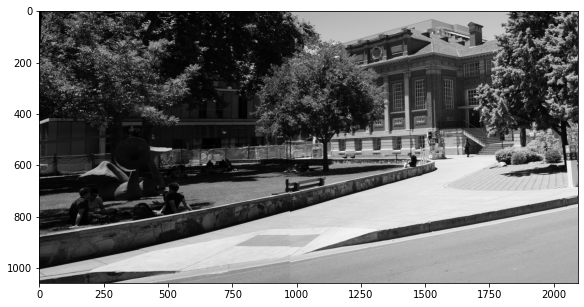

In [193]:
res = stitched[topleft_pt[1]:bottomright_pt[1], topleft_pt[0]:bottomright_pt[0]]
plt.imshow(res, cmap='gray');